# **SENTIMENT ANALYSIS - YELP REVIEWS DATA**

## Installing the necessary packages

In [1]:
!pip install langdetect


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install gcsfs


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Run below commands
!pip install --upgrade scikit-learn
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar zxvf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 340 kB in 2s (138 kB/s)
Reading package lists... Done
spark-3.4.0-bin-hadoop3/
spark-

In [4]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
sp = spacy.load('en_core_web_sm')
import tensorflow as tf
from langdetect import detect
import sys
import os
import warnings
import gcsfs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import tarfile

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql import functions as F  
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr, month, count, expr, dayofmonth
from pyspark.sql import DataFrame 
import random
import pandas as pd
from pyspark.sql.window import Window

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .getOrCreate()

In [6]:
# extracting the file from the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
json_file_path = '/content/drive/Shared drives/App domain/App Domain Project/yelp_academic_dataset_review.json'

In [8]:
'''
# Path to the tar file on Google Drive
tar_path = '/content/drive/Shared drives/App Domain/App Domain Project/yelp_dataset.tar'

# Path to the directory where files will be extracted
extracted_dir = '/content/drive/MyDrive/App Domain Project/'

# Open the tar file
tar = tarfile.open(tar_path, 'r')

# Extract the contents of the tar file
tar.extractall(extracted_dir)

# Close the tar file
tar.close()

# List the files in the extracted directory
files = os.listdir(extracted_dir)
for file in files:
    print(file)
'''


"\n# Path to the tar file on Google Drive\ntar_path = '/content/drive/Shared drives/App Domain/App Domain Project/yelp_dataset.tar'\n\n# Path to the directory where files will be extracted\nextracted_dir = '/content/drive/MyDrive/App Domain Project/'\n\n# Open the tar file\ntar = tarfile.open(tar_path, 'r')\n\n# Extract the contents of the tar file\ntar.extractall(extracted_dir)\n\n# Close the tar file\ntar.close()\n\n# List the files in the extracted directory\nfiles = os.listdir(extracted_dir)\nfor file in files:\n    print(file)\n"

In [9]:
from pyspark.sql import SparkSession

# Path to the extracted JSON file
json_file_path = '/content/drive/Shared drives/App Domain/App Domain Project/yelp_academic_dataset_review.json'

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the JSON file into a Spark DataFrame
spark_df = spark.read.json(json_file_path)

# Show the first few rows of the DataFrame
spark_df.show()



+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [10]:
# Print the schema of the Spark DataFrame
spark_df.printSchema()

# Count the number of rows in the Spark DataFrame
row_count = spark_df.count()

# Print the shape of the Spark DataFrame
# Note: Since Spark DataFrame is distributed, it doesn't have a direct shape attribute
# We can get the number of rows from the row count and the number of columns from the schema
num_columns = len(spark_df.columns)
print("Shape:", (row_count, num_columns))


root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Shape: (6990280, 9)


In [11]:
# Select the first 10000 rows from the Spark DataFrame
selected_df = spark_df.limit(10000)

# Get the number of rows in the selected DataFrame
row_count = selected_df.count()
print(row_count)

# Convert the selected portion to a Pandas DataFrame
pandas_df = selected_df.toPandas()

# Print the first few rows of the Pandas DataFrame
print(pandas_df.head())


10000
              business_id  cool                 date  funny  \
0  XQfwVwDr-v0ZS3_CbbE5Xw     0  2018-07-07 22:09:11      0   
1  7ATYjTIgM3jUlt4UM3IypQ     1  2012-01-03 15:28:18      0   
2  YjUWPpI6HXG530lwP-fb2A     0  2014-02-05 20:30:30      0   
3  kxX2SOes4o-D3ZQBkiMRfA     1  2015-01-04 00:01:03      0   
4  e4Vwtrqf-wpJfwesgvdgxQ     1  2017-01-14 20:54:15      0   

                review_id  stars  \
0  KU_O5udG6zpxOg-VcAEodg    3.0   
1  BiTunyQ73aT9WBnpR9DZGw    5.0   
2  saUsX_uimxRlCVr67Z4Jig    3.0   
3  AqPFMleE6RsU23_auESxiA    5.0   
4  Sx8TMOWLNuJBWer-0pcmoA    4.0   

                                                text  useful  \
0  If you decide to eat here, just be aware it is...       0   
1  I've taken a lot of spin classes over the year...       1   
2  Family diner. Had the buffet. Eclectic assortm...       0   
3  Wow!  Yummy, different,  delicious.   Our favo...       1   
4  Cute interior and owner (?) gave us tour of up...       1   

             

In [12]:
cols_to_drop = ['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'] 
pandas_df.drop(cols_to_drop, axis=1, inplace=True)

In [13]:
pandas_df.head()

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...


In [14]:
path1 = '/content/drive/Shared drives/App Domain/App Domain Project/yelp_academic_dataset_business.json'

In [15]:
df1 = pd.read_json(path1, lines=True)

In [16]:
df1.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [17]:
df1 = df1[df1['categories'].notnull()]
df_rest = df1[df1['categories'].str.contains('Restaurant')]

In [18]:
df_rest = df_rest[['business_id', 'categories']]

In [19]:
df_rest.head()

,business_id,categories
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,CF33F8-E6oudUQ46HnavjQ,"Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
8,k0hlBqXX-Bt0vf1op7Jr1w,"Pubs, Restaurants, Italian, Bars, American (Tr..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
11,eEOYSgkmpB90uNA7lDOMRA,"Vietnamese, Food, Restaurants, Food Trucks"


We want to merge the two datasets to analyse the restaurant reviews. "business_id" is the common columm of the two datasets

In [20]:
df_merged = pandas_df.merge(df_rest, how='inner', on='business_id')

In [21]:
df_merged.head(20)

,business_id,stars,text,categories
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...","Restaurants, Breakfast & Brunch, Food, Juice B..."
1,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
2,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
3,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,We came on a Saturday morning after waiting a ...,"Restaurants, Breakfast & Brunch, Food, Juice B..."
4,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,"Restaurants, Breakfast & Brunch"
5,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian"
6,kxX2SOes4o-D3ZQBkiMRfA,2.0,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian"
7,kxX2SOes4o-D3ZQBkiMRfA,5.0,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian"
8,kxX2SOes4o-D3ZQBkiMRfA,5.0,We've eaten here 3 times and it seems that eac...,"Halal, Pakistani, Restaurants, Indian"
9,kxX2SOes4o-D3ZQBkiMRfA,5.0,Came to Philly for a family event but stayed a...,"Halal, Pakistani, Restaurants, Indian"


Rename the text column and remove the "business_id" column because it isn't necessary anymore

In [22]:
df_merged.rename(columns={'text':'restaurant_reviews'}, inplace=True)
df_merged.drop('business_id', axis=1, inplace=True)

We will only analyse the reviews written in English

In [23]:
df_merged['detect'] = df_merged['restaurant_reviews'].apply(detect)
df_merged = df_merged[df_merged['detect'] == 'en'].reset_index(drop=True)

In [24]:
# Check if there is NaN values
df_merged.isnull().values.any()

False

In [25]:
df_merged.shape

(7097, 4)

Return the dataframe with duplicate rows removed

In [26]:
df_final = df_merged.drop_duplicates(inplace=False)

If we want to save some ram memory:

In [27]:
del df_merged, df_rest

In [28]:
df_final.shape

(7097, 4)

As many of the 3 stars reviews, most likely, have both good and bad aspects/feelings, we will remove those reviews so they won't harm our sentiment analysis

In [29]:
df_final = df_final[(df_final["stars"]!=3)]
df_final.head(20)

,stars,restaurant_reviews,categories,detect
1,2.0,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en
2,4.0,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en
5,5.0,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian",en
6,2.0,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian",en
7,5.0,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian",en
8,5.0,We've eaten here 3 times and it seems that eac...,"Halal, Pakistani, Restaurants, Indian",en
9,5.0,Came to Philly for a family event but stayed a...,"Halal, Pakistani, Restaurants, Indian",en
10,5.0,A very neat little hole in the wall. Very clea...,"Halal, Pakistani, Restaurants, Indian",en
11,4.0,This place was a great find. I'd say its a 4.5...,"Halal, Pakistani, Restaurants, Indian",en
12,4.0,I've been here several times. The price is rea...,"Halal, Pakistani, Restaurants, Indian",en


Label reviews as positive - 1 - or negative - 0 - and after that remove the "stars" column, it is not needed anymore

In [30]:
df_final.loc[df_final['stars'] < 3, 'sentiment'] = 0 
df_final.loc[df_final['stars'] > 3, 'sentiment'] = 1
df_final.drop('stars', axis=1, inplace=True)
df_final.head(20)

,restaurant_reviews,categories,detect,sentiment
1,This is the second time we tried turning point...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en,0.0
2,The place is cute and the staff was very frien...,"Restaurants, Breakfast & Brunch, Food, Juice B...",en,1.0
5,"Wow! Yummy, different, delicious. Our favo...","Halal, Pakistani, Restaurants, Indian",en,1.0
6,Dine-in gets 2 stars. Disappointing service & ...,"Halal, Pakistani, Restaurants, Indian",en,0.0
7,After a long hiatus from reviewing I have awak...,"Halal, Pakistani, Restaurants, Indian",en,1.0
8,We've eaten here 3 times and it seems that eac...,"Halal, Pakistani, Restaurants, Indian",en,1.0
9,Came to Philly for a family event but stayed a...,"Halal, Pakistani, Restaurants, Indian",en,1.0
10,A very neat little hole in the wall. Very clea...,"Halal, Pakistani, Restaurants, Indian",en,1.0
11,This place was a great find. I'd say its a 4.5...,"Halal, Pakistani, Restaurants, Indian",en,1.0
12,I've been here several times. The price is rea...,"Halal, Pakistani, Restaurants, Indian",en,1.0


In [31]:
df_final.dtypes

restaurant_reviews     object
categories             object
detect                 object
sentiment             float64
dtype: object

Let's see if the dataset is balanced or not: it isn't...

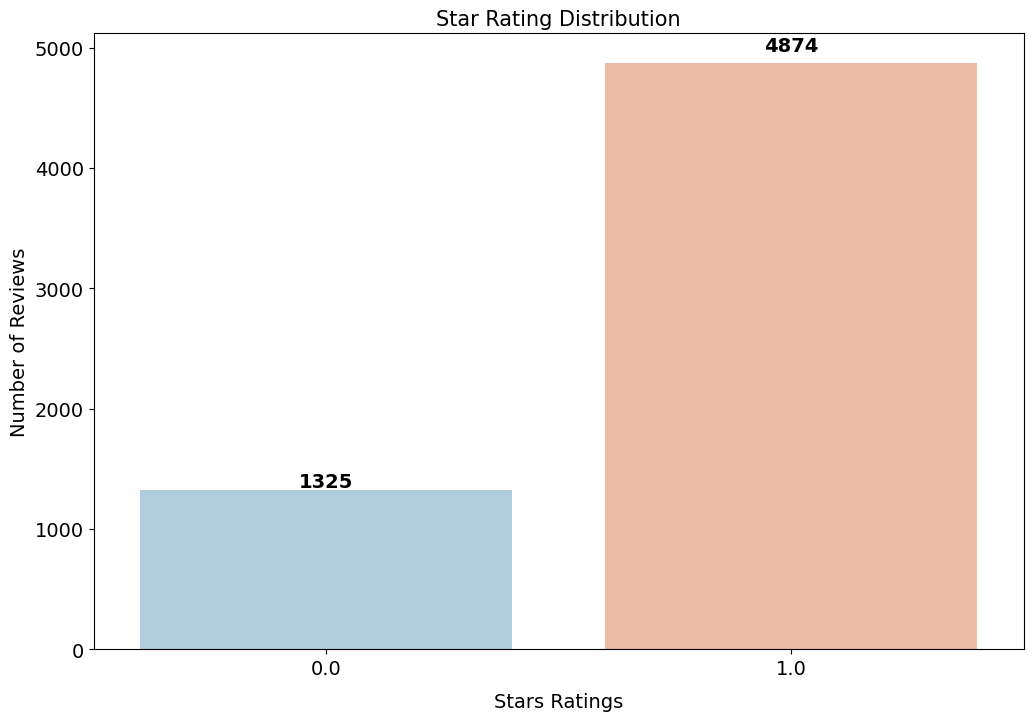

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

plt.figure(figsize=(12, 8))
grouped = df_final.sentiment.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette="RdBu_r")
plt.xlabel('Stars Ratings', labelpad=10, fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.title('Star Rating Distribution', fontsize=15)
plt.tick_params(labelsize=14)
for i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment='center', fontweight='bold', fontsize=14)
plt.show()


To deal with imbalanced data we chose to upsample the minority class (negative sentiment - 0)

In [33]:
from sklearn.utils import resample
# upsample minority class
#create two different dataframes: one regarding the majority and the other the minority class 
df_majority = df_final[(df_final['sentiment']==1)] 
df_minority = df_final[(df_final['sentiment']==0)] 


df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples= 4874, # to match majority class
                                 random_state=42)  
# Combine majority class with upsampled minority class
df_final = pd.concat([df_minority_upsampled, df_majority])

In [34]:
df_final.sentiment.value_counts()

0.0    4874
1.0    4874
Name: sentiment, dtype: int64

In [35]:
df_final = df_final.reset_index(drop=True)
df_final.head()

,restaurant_reviews,categories,detect,sentiment
0,This was by far the worst dinner I have ever h...,"Pizza, Restaurants, Italian",en,0.0
1,Ordered from grubhub waited an hour and a half...,"Food Delivery Services, Halal, Food, Restauran...",en,0.0
2,It was... not good. We got there late-ish on ...,"American (New), Vegetarian, Restaurants, Burgers",en,0.0
3,"The food is great, but I just waited 20 minute...","American (Traditional), Breakfast & Brunch, Re...",en,0.0
4,"Worst customer service ever, food is par by fa...","Restaurants, Pizza",en,0.0


Stopwords with spaCy. As 'no' and 'not' are important words to describe an opinion about a restaurant (e.g. not cheap, not a good service, no napkins available, etc.), we should, at least, remove those two words from the stopwords.

In [36]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

exclude_stopwords = ['no','not']
for word in exclude_stopwords:
    stopwords.remove(word)

UDF to use spaCy to lemmatize and filter the stopwords, then remove non-letters and convert the restaurant reviews to lower case .

In [37]:
def spacy_process(text):
    doc = sp(text)
    
# Lemmatization with Spacy

    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
            
    #Filter the stopwords, remove non-letters and lower case 
    
    filtered_sentence =[] 
    for word in lemma_list:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    lower_words = []
    for word in filtered_sentence:
        text_letters_only = re.sub("[^a-zA-Z]", " ", word) 
        text_words_lower = text_letters_only.lower()  
        lower_words.append(text_words_lower)
    text_final = " ".join(lower_words)
    return  " ".join(text_final.split())

An example

In [38]:
spacy_process(df_final['restaurant_reviews'][0])

'far bad dinner eat meatball pasta pizza sauce cold nd eat bite clam linguini cup olive oil bowl no garlic seasoning rd cook chicken parm eggplant parm dry cook ravioli salt pizza sauce melt cheese service bad no compensation hour serve'

Apply the above UDF to the entire 'restaurant_reviews' column, creating a new column named cleaned_reviews'

In [39]:
df_final['cleaned_reviews'] = df_final['restaurant_reviews'].apply(spacy_process)

In [40]:
df_final.isnull().values.any()

False

In [41]:
df_final.head()

,restaurant_reviews,categories,detect,sentiment,cleaned_reviews
0,This was by far the worst dinner I have ever h...,"Pizza, Restaurants, Italian",en,0.0,far bad dinner eat meatball pasta pizza sauce ...
1,Ordered from grubhub waited an hour and a half...,"Food Delivery Services, Halal, Food, Restauran...",en,0.0,order grubhub wait hour half delivery naturall...
2,It was... not good. We got there late-ish on ...,"American (New), Vegetarian, Restaurants, Burgers",en,0.0,good late ish sunday service obvious care burg...
3,"The food is great, but I just waited 20 minute...","American (Traditional), Breakfast & Brunch, Re...",en,0.0,food great wait minute carry order credit card...
4,"Worst customer service ever, food is par by fa...","Restaurants, Pizza",en,0.0,bad customer service food par far dirty table ...


Let's save the dataset with only the columns of our interest to the bucket

In [42]:
df_final = df_final[['cleaned_reviews','sentiment']]

In [43]:
# File path in Google Drive
csv_file_path = '/content/drive/MyDrive/App Domain Project/df_final.csv'

# Save the DataFrame to a CSV file
df_final.to_csv(csv_file_path, index=False)


# **Text Vectorization techniques**

---



## 1. Bag of Words

In [44]:
import pandas as pd
import numpy as np

In [45]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .getOrCreate()

In [46]:
df_final = pd.read_csv('/content/drive/Shared drives/App Domain/App Domain Project/df_final.csv')
df_final.head()

,cleaned_reviews,sentiment
0,far bad dinner eat meatball pasta pizza sauce ...,0.0
1,order grubhub wait hour half delivery naturall...,0.0
2,good late ish sunday service obvious care burg...,0.0
3,food great wait minute carry order credit card...,0.0
4,bad customer service food par far dirty table ...,0.0


In [47]:
spark_df = spark.createDataFrame(df_final)

In [48]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.ml import Pipeline

# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_reviews", outputCol="words")
spark_df = tokenizer.transform(spark_df)

# Create an instance of CountVectorizer
vectorizer = CountVectorizer(inputCol="words", outputCol="bow_features")

# Fit the vectorizer on the PySpark DataFrame
vectorizer_model = vectorizer.fit(spark_df)
bow_df = vectorizer_model.transform(spark_df)

# View the Bag of Words features
bow_df.select("bow_features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bow_features                                                                                                                                                   

In [49]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = bow_df.select("bow_features").toPandas()

# Access the "bow_features" column in the Pandas DataFrame
bow_features = pandas_df["bow_features"]

# Print the Bag of Words features
print(bow_features)


0       (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
1       (0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       (0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
3       (4.0, 0.0, 0.0, 4.0, 2.0, 2.0, 0.0, 0.0, 0.0, ...
4       (2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, ...
                              ...                        
9745    (0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9746    (1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
9747    (1.0, 4.0, 4.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...
9748    (1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
9749    (0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...
Name: bow_features, Length: 9750, dtype: object


In [50]:
# Get the vocabulary from the CountVectorizerModel
vocabulary = vectorizer_model.vocabulary

# Interpret the Bag of Words features for the first document
first_document_features = bow_features[0]
for index, count in enumerate(first_document_features):
    if count > 0:
        word = vocabulary[index]
        print(f"Word '{word}' appears {count} time(s) in the document.")


Word 'service' appears 1.0 time(s) in the document.
Word 'no' appears 2.0 time(s) in the document.
Word 'eat' appears 2.0 time(s) in the document.
Word 'chicken' appears 1.0 time(s) in the document.
Word 'bad' appears 2.0 time(s) in the document.
Word 'pizza' appears 2.0 time(s) in the document.
Word 'sauce' appears 2.0 time(s) in the document.
Word 'cheese' appears 1.0 time(s) in the document.
Word 'serve' appears 1.0 time(s) in the document.
Word 'hour' appears 1.0 time(s) in the document.
Word 'dinner' appears 1.0 time(s) in the document.
Word 'cook' appears 2.0 time(s) in the document.
Word 'cold' appears 1.0 time(s) in the document.
Word 'far' appears 1.0 time(s) in the document.
Word 'dry' appears 1.0 time(s) in the document.
Word 'bite' appears 1.0 time(s) in the document.
Word 'cup' appears 1.0 time(s) in the document.
Word 'garlic' appears 1.0 time(s) in the document.
Word 'pasta' appears 1.0 time(s) in the document.
Word 'bowl' appears 1.0 time(s) in the document.
Word 'salt'

## 2.TF-IDF

In [51]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="cleaned_reviews", outputCol="idf_words")
tokenized_df = tokenizer.transform(spark_df)

vectorizer = CountVectorizer(inputCol="idf_words", outputCol="raw_features")
vectorizer_model = vectorizer.fit(tokenized_df)

raw_features_df = vectorizer_model.transform(tokenized_df)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

idf_model = idf.fit(raw_features_df)
tfidf_df = idf_model.transform(raw_features_df)

In [52]:
tfidf_features = tfidf_df.select("tfidf_features").collect()
import pandas as pd

tfidf_df_pd = pd.DataFrame(tfidf_features, columns=["tfidf_features"])

# View the first few rows of the DataFrame
print(tfidf_df_pd.head())


                                      tfidf_features
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.11891755...
1  (0.0, 0.0, 0.0, 2.3113845645077524, 0.0, 0.0, ...
2  (0.0, 0.8525761835824816, 0.873972574833429, 0...
3  (2.7845026631586545, 0.0, 0.0, 4.6227691290155...
4  (1.3922513315793272, 0.0, 0.0, 0.0, 1.25168673...


In [53]:
# Get the dimensions of the DataFrame
print("Dimensions:", tfidf_df_pd.shape)

Dimensions: (9750, 1)


In [54]:
# Compute descriptive statistics of the TF-IDF features
print("Descriptive Statistics:")
print(tfidf_df_pd.describe())

Descriptive Statistics:
                                           tfidf_features
count                                                9750
unique                                               6160
top     (0.0, 0.8525761835824816, 0.873972574833429, 1...
freq                                                   11


# 3.nGrams


In [55]:
from pyspark.sql.functions import split
from pyspark.ml.feature import NGram

# Convert the "cleaned_reviews" column into an array of strings
df = spark_df.withColumn("cleaned_reviews_array", split("cleaned_reviews", " "))

# Create an instance of NGram with the desired n value
ngram = NGram(n=2, inputCol="cleaned_reviews_array", outputCol="ngrams")

# Apply the n-grams transformation on the DataFrame
ngram_df = ngram.transform(df)

# Show the resulting DataFrame
ngram_df.show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
from pyspark.sql.functions import explode, col

# Explode the ngrams column to create one row for each n-gram
exploded_df = ngram_df.select(explode(col("ngrams")).alias("ngram"))

# Count the occurrence of each n-gram
ngram_counts = exploded_df.groupBy("ngram").count().orderBy(col("count").desc())

# Show the n-gram counts
ngram_counts.show(truncate=False)


+----------------+-----+
|ngram           |count|
+----------------+-----+
|food good       |436  |
|taste like      |384  |
|customer service|305  |
|feel like       |299  |
|great food      |291  |
|wait minute     |280  |
|food great      |274  |
|good food       |256  |
|look like       |245  |
|highly recommend|242  |
|happy hour      |238  |
|service great   |232  |
|great service   |227  |
|love place      |224  |
|food service    |214  |
|ice cream       |210  |
|food come       |209  |
|pretty good     |203  |
|good service    |200  |
|long time       |196  |
+----------------+-----+
only showing top 20 rows



# Classification Models

In [57]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

In [58]:
df_final = pd.read_csv('/content/drive/Shared drives/App Domain/App Domain Project/df_final.csv')
df_final.head()

,cleaned_reviews,sentiment
0,far bad dinner eat meatball pasta pizza sauce ...,0.0
1,order grubhub wait hour half delivery naturall...,0.0
2,good late ish sunday service obvious care burg...,0.0
3,food great wait minute carry order credit card...,0.0
4,bad customer service food par far dirty table ...,0.0


Train/test split keeping the two columns of interest and preserve the same proportions of examples in each class as observed in the original dataset

In [59]:
X = df_final['cleaned_reviews'] 
y = df_final['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [60]:
X_train.head()

9207    platter tasty vegetable like onion pepper cucu...
8424    travel lot love indian food end try lot indian...
7871    waffle house consistent quality fond business ...
2855    terrace lounge appear want great cocktail venu...
9237    new restaurant neighborhood finally open satur...
Name: cleaned_reviews, dtype: object

In [61]:
X_train.shape

(6825,)

In [62]:
X_train.isnull().any().any()

False

In [63]:
y_train.head()

9207    1.0
8424    1.0
7871    1.0
2855    0.0
9237    1.0
Name: sentiment, dtype: float64

In [64]:
y_train.shape

(6825,)

UDF for evaluating models

In [65]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [66]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(y_test, predictions, predicted_probabilities):
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    accuracy = accuracy_score(y_test, predictions)
    print("Model Accuracy:", accuracy)


**Model Development and Evaluation for Sentiment Analysis using Logistic Regression, SVM, and Random Forest**

Logistic Regression:


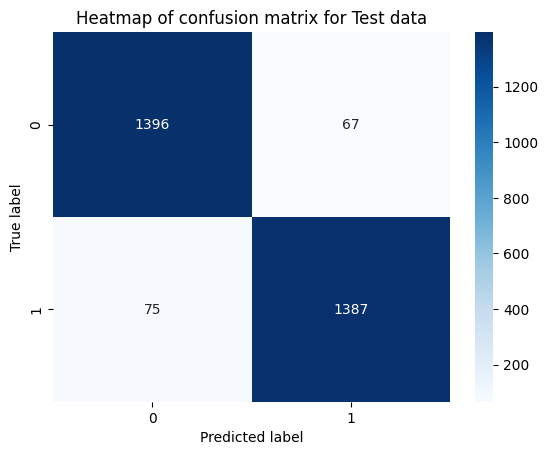

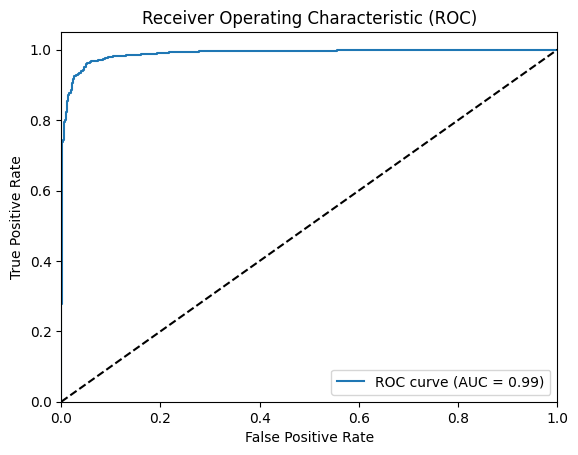

Model Accuracy: 0.9514529914529914
Support Vector Machines (SVM):


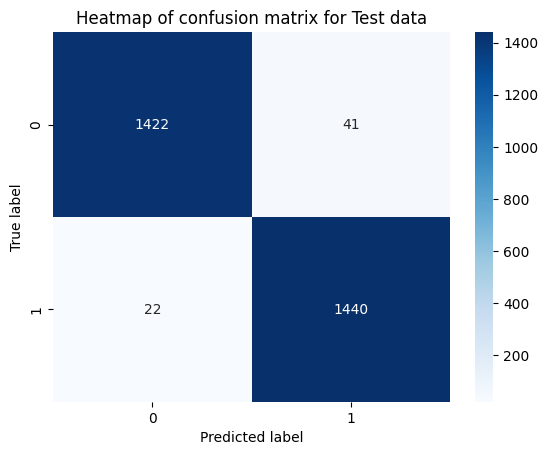

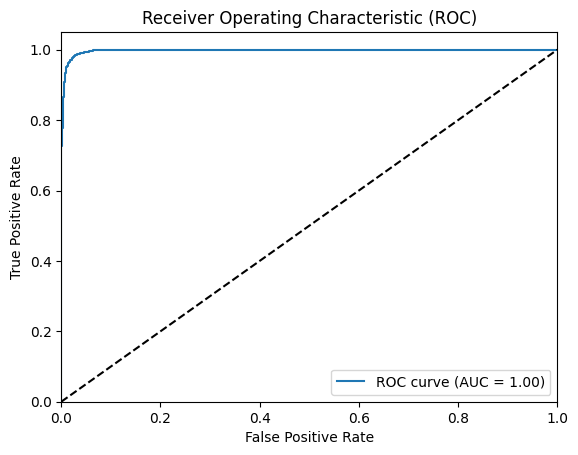

Model Accuracy: 0.9784615384615385
Random Forest:


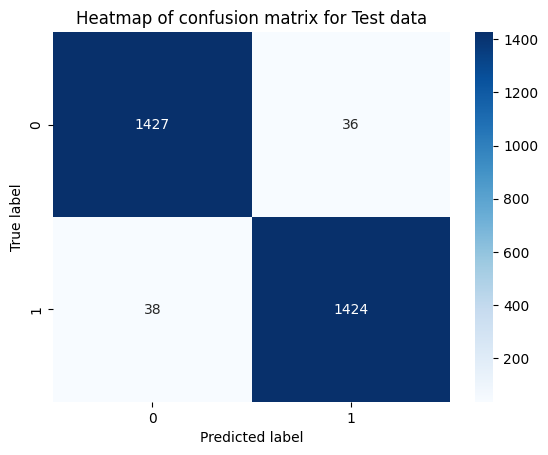

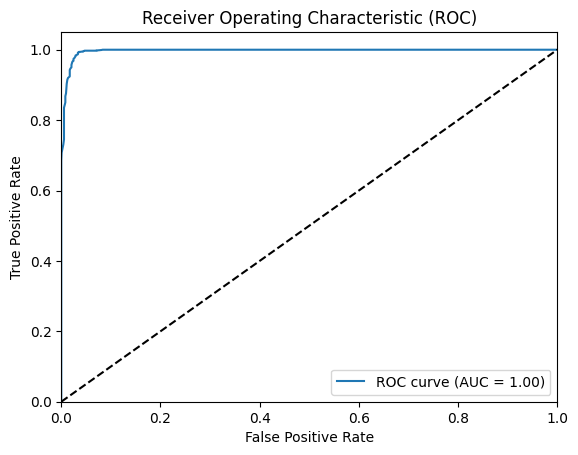

Model Accuracy: 0.9747008547008547


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)
logreg_predictions = logreg_model.predict(X_test_tfidf)
logreg_probabilities = logreg_model.predict_proba(X_test_tfidf)[:, 1]

# Support Vector Machines (SVM)
svm_model = SVC(probability=True)
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)
svm_probabilities = svm_model.predict_proba(X_test_tfidf)[:, 1]

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_predictions = rf_model.predict(X_test_tfidf)
rf_probabilities = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate Logistic Regression model
print("Logistic Regression:")
evaluate(y_test, logreg_predictions, logreg_probabilities)

# Evaluate Support Vector Machines (SVM) model
print("Support Vector Machines (SVM):")
evaluate(y_test, svm_predictions, svm_probabilities)

# Evaluate Random Forest model
print("Random Forest:")
evaluate(y_test, rf_predictions, rf_probabilities)
